## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cat ml-1m/README

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [4]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [5]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [6]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [7]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [8]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [9]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [ ]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    matrix_shape = (df_train['user_id'].nunique(), 
                    df_train['item_id'].nunique())
    result = np.zeros(matrix_shape)
    result[df.user_id.values, df.item_id.values] = df.rating.values
    return result  # shape ~ [n_users, n_items]

In [17]:
interactions = df_to_matrix(df_train)

In [ ]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    matrix_shape = (df_train['user_id'].nunique(), 
                    df_train['item_id'].nunique())
    result = coo_array(
        (df.rating.values.astype(float), (df.user_id.values, df.item_id.values)),
        shape=(matrix_shape)
    )
    return result # coo_array

In [19]:
coo_interactions = df_to_coo(df_train)

In [20]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [ ]:
import scipy.sparse
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    if isinstance(interactions, coo_array):
        if n_singular_values > 0:
            U, S, V = scipy.sparse.linalg.svds(interactions, 
                                               k=n_singular_values, random_state=228_322)
        else:
            U, S, V = scipy.sparse.linalg.svds(interactions, 
                                               k=min(interactions.shape) - 1, random_state=228_322)
        S = np.diag(S)
        return U, S, V
    if isinstance(interactions, np.ndarray):
        U, S, V = np.linalg.svd(interactions)
        U = U[:, :min(U.shape[0], V.shape[1])]
        V = V[:min(U.shape[0], V.shape[1]), :]
        S = np.diag(S)
        if n_singular_values > 0:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values, :n_singular_values]
            V = V[:n_singular_values, :]
        return U, S, V
    raise ValueError(f"The input datatype is of unknown type: {type(interactions)}")
    
    
    

In [23]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [24]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [25]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)
    svd_predictions = U @ S @ V
    
    if isinstance(interactions, np.ndarray):
        svd_predictions[np.where(interactions > 0)] = -np.inf
    elif isinstance(interactions, coo_array):
        svd_predictions[scipy.sparse.find(coo_interactions > 0)[:2]] = -np.inf
    else:
        raise ValueError(f"The input datatype is of unknown type: {type(interactions)}")

    recommendations = np.argsort(-1 * svd_predictions, axis=1)[:, :top_k]
    del svd_predictions
    return recommendations #shape ~ [n_users, top_k]

In [26]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [ ]:
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm


def le_compute_le_ndcg(df_test, recs, verbose=False):
    y_true = np.zeros_like(recs, dtype=int)
    y_pred = -np.tile(np.arange(recs.shape[1]), 
                      (recs.shape[0], 1))
    user_item_pairs = df_test.groupby("user_id")["item_id"].apply(lambda x: x.values).to_dict()
    for user_id in tqdm(range(recs.shape[0]), disable=not verbose):
        if user_id in user_item_pairs:
            y_true[user_id] = np.isin(recs[user_id], 
                                      user_item_pairs[user_id]).astype(int)
    score = ndcg_score(y_true, y_pred, k=y_pred.shape[1])
    return score

import time
import seaborn as sns
import matplotlib.pyplot as plt

def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    #your code here
    scores = []
    times = []

    for n_singular_values in [1, 10, 50, 200, 1000]:
        start = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values, top_k)
        end = time.time()
        times.append(end - start)
        scores.append(le_compute_le_ndcg(df_test, recs))
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)

    sns.lineplot(x=[1, 10, 50, 200, 1000], y=scores, ax=ax[0])
    ax[0].set_xlabel("n_singular_values")
    ax[0].set_ylabel(f"nDCG @ {top_k}")
    sns.lineplot(x=[1, 10, 50, 200, 1000], y=times, ax=ax[1])
    ax[1].set_xlabel("n_singular_values")
    ax[1].set_ylabel("Time")


    plt.tight_layout()
    plt.show()



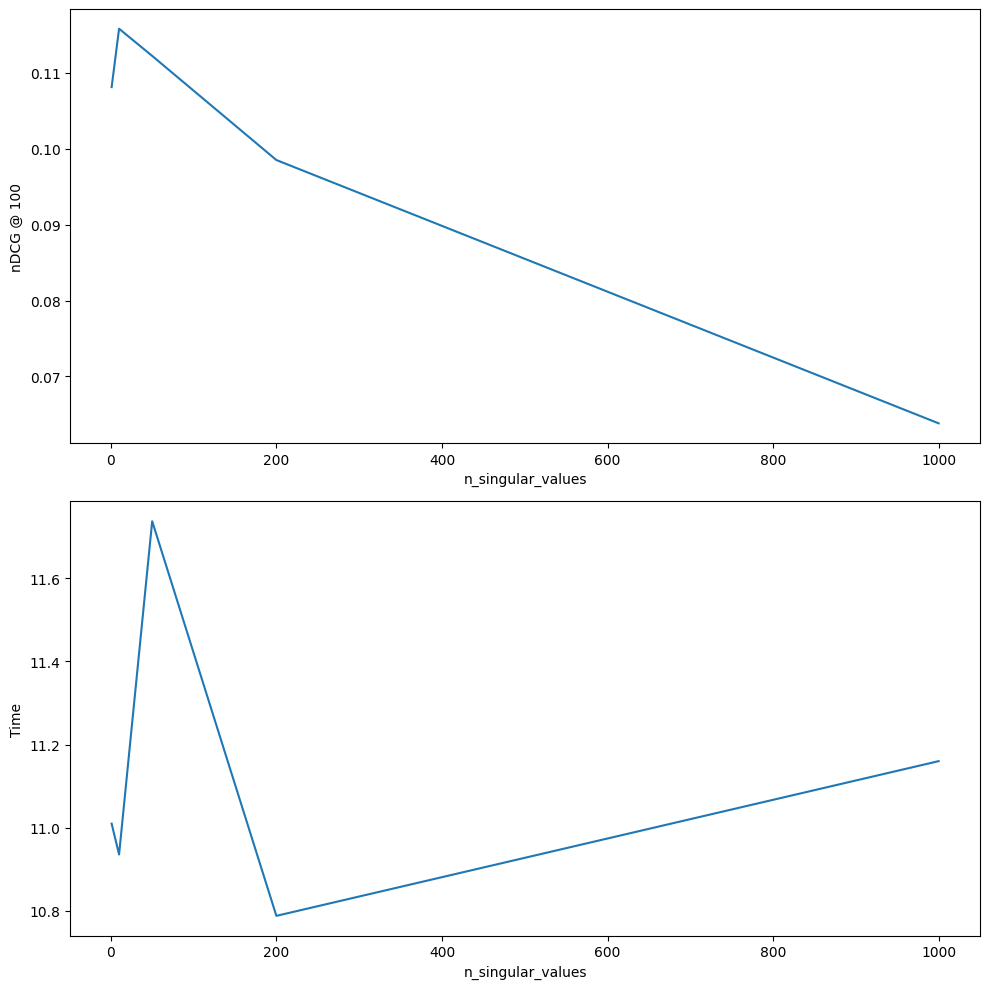

In [38]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [39]:
%pip install implicit

     -------------------------------------- 748.6/748.6 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
from implicit.cpu.als import AlternatingLeastSquares
from copy import deepcopy

def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
    model_needed  = False

):
    ints = scipy.sparse.csr_matrix(deepcopy(interactions))
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        random_state=228_322
    )
    model.fit(ints)
    recommendations = model.recommend(
        userid=np.arange(ints.shape[0]),
        user_items=ints,filter_already_liked_items=True, N=top_k)[0]
    del ints
    if model_needed:
        return recommendations, model
    return recommendations #shape ~ [n_users, top_k]


In [44]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

c:\Users\User\miniconda3\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
c:\Users\User\miniconda3\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
print(f"{le_compute_le_ndcg(df_test, make_svd_recommendations(coo_interactions, 15, 100))}")

0.11472723604860942


In [49]:
print(f"ALS: {le_compute_le_ndcg(df_test, recs)}") # worse than SVD!

ALS: 0.10709830307948542


In [ ]:
def find_best_als_parameters(interactions, df_test, alphas, regularizations, n_factors_list):
    max_score = 0
    best_combination = None
    res = []

    for alpha in tqdm(alphas, desc="Alphas"):
        for regularization in tqdm(regularizations, desc="Regularizations", leave=False):
            for n_factors in tqdm(n_factors_list, desc="n_factors", leave=False):
          
                recs = make_als_recommendations(
                    interactions,
                    n_factors=n_factors,
                    alpha=alpha,
                    regularization=regularization,
                )
                score = le_compute_le_ndcg(df_test, recs)
                if score > max_score:
                    print(f"New best score {score}. Parameters: {alpha}, {regularization}, {n_factors}")
                    best_combination = (alpha, regularization, n_factors)
                    max_score = score
                res.append((score, alpha, regularization, n_factors))
    
    return best_combination, max_score, res

In [54]:
alphas = [0, 0.5, 1, 2]
regularizations = [0.005, 0.01, 0.05, 0.1]
n_factors_list = [20, 50, 100, 150]
best_combination, max_score, results = find_best_als_parameters(
    interactions, df_test, alphas, regularizations, n_factors_list
)

print(f"Best combination: {best_combination}")
print(f"Max nDCG score: {max_score}")

Alphas:   0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

New best score 0.05826354614299175. Parameters: 0, 0.005, 20


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

New best score 0.0590359519829841. Parameters: 0, 0.01, 100


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

New best score 0.07749619114349493. Parameters: 0, 0.05, 100


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Alphas:  25%|██▌       | 1/4 [00:41<02:03, 41.24s/it]


  0%|          | 0/15 [00:00<?, ?it/s]

New best score 0.1130127990660259. Parameters: 0.5, 0.005, 20


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Alphas:  50%|█████     | 2/4 [01:18<01:17, 38.90s/it]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Alphas:  75%|███████▌  | 3/4 [01:56<00:38, 38.59s/it]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Alphas: 100%|██████████| 4/4 [02:35<00:00, 38.76s/it]

Best combination: (0.5, 0.005, 20)
Max nDCG score: 0.1130127990660259


In [55]:
print(f"Best combination: {best_combination}")
print(f"Max nDCG score: {max_score}")

Best combination: (0.5, 0.005, 20)
Max nDCG score: 0.1130127990660259


SVD показало себя лучше, чем ALS без тюнинга и сравнимо с ALS после него

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [56]:
df_movies = pd.read_csv("ml-1m/movies.dat", sep=r'::', 
                        names=["item_id", "name", "genre"], engine="python", encoding="ISO-8859-1")


In [58]:
seed = 228_322
recs, model = make_als_recommendations(interactions, model_needed=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [68]:
from scipy.sparse import csr_matrix
def explain_recommendations_for_users(df_train, 
                                      recs, 
                                      interactions, 
                                      item_le, 
                                      df_movies, 
                                      model, 
                                      seed=None, 
                                      n_users=3):
    sampled_users = df_train.sample(n=n_users, 
                                    random_state=seed)["user_id"].values
    for user in sampled_users:
        user_recs = recs[user]
        imp_movies = [i[0] for i in model.explain(user, csr_matrix(interactions), user_recs[0])[1]]
        most_recom_id = item_le.inverse_transform([user_recs[0]])[0]
        imp_movies_ids = item_le.inverse_transform(imp_movies)
        print(f"\nUser: {user}")
        print("Most recommended movie:")
        print(f" id={most_recom_id}, name={df_movies.loc[df_movies.item_id == most_recom_id, 'name'].values[0]}, genre={df_movies.loc[df_movies.item_id == most_recom_id, 'genre'].values[0]}")
        print("The user watched this to be recommended:")
        for number, i   in enumerate(imp_movies_ids):
            print(f"\t {number+1}: id={i}, name={df_movies.loc[df_movies.item_id == i, 'name'].values[0]}, genre={df_movies.loc[df_movies.item_id == i, 'genre'].values[0]}")

In [69]:
explain_recommendations_for_users(
    df_train=df_train, 
    recs=recs,  
    interactions=interactions,  
    item_le=item_le,  
    df_movies=df_movies, 
    model=model, 
    seed=228_322, 
    n_users=3
)


User: 2405
Most recommended movie:
 id=595, name=Beauty and the Beast (1991), genre=Animation|Children's|Musical
The user watched this to be recommended:
	 1: id=364, name=Lion King, The (1994), genre=Animation|Children's|Musical
	 2: id=588, name=Aladdin (1992), genre=Animation|Children's|Comedy|Musical
	 3: id=2687, name=Tarzan (1999), genre=Animation|Children's
	 4: id=1907, name=Mulan (1998), genre=Animation|Children's
	 5: id=2081, name=Little Mermaid, The (1989), genre=Animation|Children's|Comedy|Musical|Romance
	 6: id=1022, name=Cinderella (1950), genre=Animation|Children's|Musical
	 7: id=1, name=Toy Story (1995), genre=Animation|Children's|Comedy
	 8: id=2355, name=Bug's Life, A (1998), genre=Animation|Children's|Comedy
	 9: id=594, name=Snow White and the Seven Dwarfs (1937), genre=Animation|Children's|Musical
	 10: id=1282, name=Fantasia (1940), genre=Animation|Children's|Musical

User: 349
Most recommended movie:
 id=480, name=Jurassic Park (1993), genre=Action|Adventure|

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
#пункт 1
interactions_1 = deepcopy(interactions)
interactions_1[interactions_1 > 0] = 1
svd_recs = make_svd_recommendations(coo_array(interactions_1), 15, 100)
als_recs = make_als_recommendations(interactions_1, n_factors=20, 
                                    alpha=0.5, regularization=0.05)
print(f"SVD:{le_compute_le_ndcg(df_test, svd_recs)}")
print(f"ALS: {le_compute_le_ndcg(df_test, als_recs)}")
del interactions_1

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:0.11472723604860942
ALS: 0.11290796938050808


In [79]:
#пункт 2
interactions_2 = deepcopy(interactions)
interactions_2[interactions_2 >= 4] = 1
interactions_2[interactions_2 <= 3] = 0
svd_recs = make_svd_recommendations(coo_array(interactions_2), 15, 100)
als_recs = make_als_recommendations(interactions_2, n_factors=20, 
                                    alpha=0.5, regularization=0.05)
print(f"SVD:{le_compute_le_ndcg(df_test, svd_recs)}")
print(f"ALS: {le_compute_le_ndcg(df_test, als_recs)}")
del interactions_2

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:0.11472723604860942
ALS: 0.11290796938050808


In [74]:
#пункт 3
interactions_1 = deepcopy(interactions)
interactions_1[interactions_1 >= 4] = 1
interactions_1[interactions_1 <= 3] = -1
svd_recs = make_svd_recommendations(coo_array(interactions_1), 15, 100)
als_recs = make_als_recommendations(interactions_1, n_factors=20, 
                                    alpha=0.5, regularization=0.05)
print(f"SVD:{le_compute_le_ndcg(df_test, svd_recs)}")
print(f"ALS: {le_compute_le_ndcg(df_test, als_recs)}")
del interactions_1

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:0.11472723604860942
ALS: 0.11290796938050808


In [75]:
print(df_train["datetime"].min(), df_train["datetime"].min().month)
print(df_train["datetime"].max(), df_train["datetime"].max().month)

2000-04-25 23:05:32 4
2000-11-30 23:59:47 11


In [ ]:
# lдобавим сглаживание по формуле - w = (n-4) / 7 где n = месяц, в котором была сделана положительная интеракция
def compute_ratings(df_train):
    ratings = np.where(df_train["rating"] <= 3, -1, 0)
    weights = (df_train["datetime"].dt.month - 4) / 7
    ratings[df_train["rating"] > 3] = df_train.loc[df_train["rating"] > 3, "rating"] * weights[df_train["rating"] > 3]
    return ratings

ratings = compute_ratings(df_train)

In [78]:
#пункт 4
interactions_1 = deepcopy(df_train).assign(rating=ratings)
svd_recs = make_svd_recommendations(coo_array(interactions_1), 15, 100)
als_recs = make_als_recommendations(interactions_1, n_factors=20, 
                                    alpha=0.5, regularization=0.05)
print(f"SVD:{le_compute_le_ndcg(df_test, svd_recs)}")
print(f"ALS: {le_compute_le_ndcg(df_test, als_recs)}")
del interactions_1

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:0.11472723604860942
ALS: 0.11290796938050808


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [99]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [96]:
class iALS:
    def __init__(self, n_factors=100, alpha=1.0, reg_coef=0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        
    def fit(self, interactions, n_iterations=10, verbose=True):
        n_users, n_items = interactions.shape
        C = 1 + self.alpha * interactions
        
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))
        
        I = np.eye(self.n_factors) * self.reg_coef
        
        for _ in tqdm(range(n_iterations), disable=not verbose):
            YTY = self.item_factors.T @ self.item_factors + I
            CuPu = C @ self.item_factors
            self.user_factors = np.linalg.solve(YTY, CuPu.T).T
            
            XTX = self.user_factors.T @ self.user_factors + I
            CiPi = C.T @ self.user_factors
            self.item_factors = np.linalg.solve(XTX, CiPi.T).T
            
    def predict(self, interactions, top_k=100):
        scores = self.user_factors @ self.item_factors.T
        scores[interactions > 0] = -np.inf
        return np.argsort(-scores, axis=1)[:, :top_k]

In [92]:
model = iALS()
model.fit(interactions)
recs_manual = model.predict(interactions)

100%|██████████| 10/10 [00:00<00:00, 17.95it/s]


In [93]:
recs = make_als_recommendations(interactions)

  0%|          | 0/15 [00:00<?, ?it/s]

In [98]:
print(f"Custom {le_compute_le_ndcg(df_test, recs_manual)}")
print(f"Library {le_compute_le_ndcg(df_test, recs)}")
#качество стравнимо!!

Custom 0.10796147560464806
Library 0.10709830307948542
